In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#angepasste Vorlage aus dogs vs. cats von kaggle
# Standard library
import copy
import glob
import multiprocessing
import os
import time
import zipfile

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Related third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io, transform
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

#train_dir = '/content/drive/MyDrive/Gruppenarbeit_NN/Dataset/train1/train'
#test_dir = '/content/drive/MyDrive/Gruppenarbeit_NN/Dataset/test'

with zipfile.ZipFile('/content/drive/MyDrive/Gruppenarbeit_NN/Dataset/data.zip') as entire_zip:
     entire_zip.extractall('.')
with zipfile.ZipFile('./train.zip') as train_zip:
     train_zip.extractall('.')
with zipfile.ZipFile('./test.zip') as test_zip:
     test_zip.extractall('.')

train_dir = './train'
test_dir = './test'

Constants

Regarding input_size, mean and std, all pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [ ]:
input_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Number of classes in the dataset
num_classes = 2 # dog, cat

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 2

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Switch to perform multi-process data loading
num_workers = multiprocessing.cpu_count()

Helper Functions

In [ ]:
# train data file looks './train/dog.10435.jpg'
# test data file looks './test/10435.jpg'
def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    history = {'accuracy': [],
               'val_accuracy': [],
               'loss': [],
               'val_loss': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                history['accuracy'].append(epoch_acc.item())
                history['loss'].append(epoch_loss)
            else:
                history['val_accuracy'].append(epoch_acc.item())
                history['val_loss'].append(epoch_loss) 

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Load Data

In [ ]:
all_train_files = glob.glob(os.path.join(train_dir, '*.jpg'))
train_list, val_list = train_test_split(all_train_files, random_state=42)

In [ ]:
print(len(train_list))
print(len(val_list))

18750
6250


Checks what train data looks like

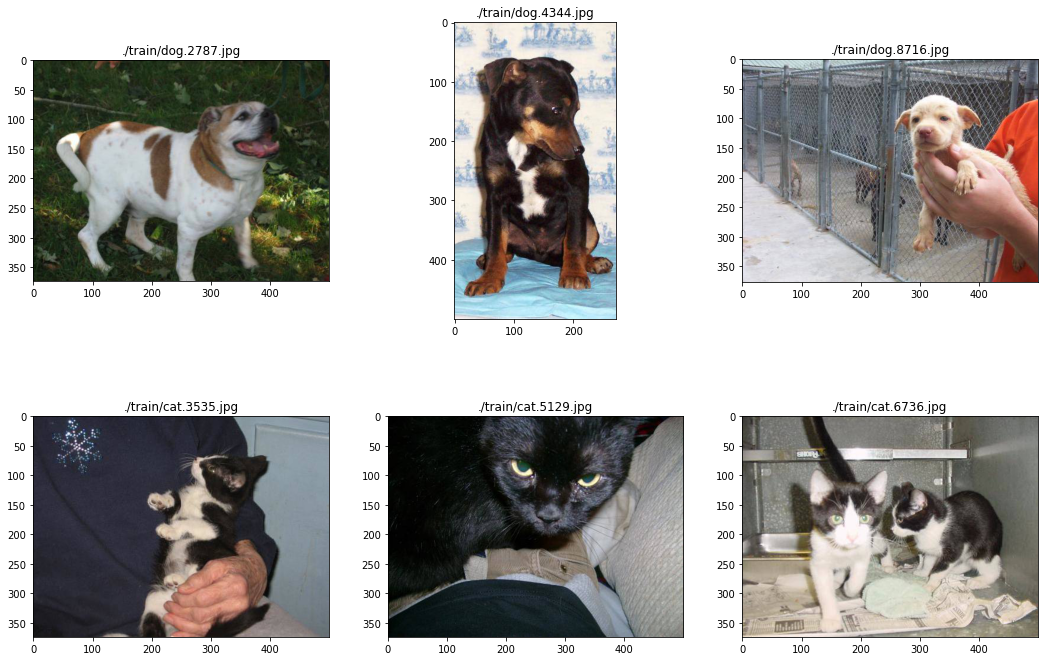

In [ ]:
fig, axes = plt.subplots(nrows=2,
                         ncols=3,
                         figsize=(18, 12))
for img_path, ax in zip(train_list, axes.ravel()):
    ax.set_title(img_path)
    ax.imshow(Image.open(img_path))

Dataset class

In [ ]:
class DogVsCatDataset(Dataset):
  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
  
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
    
        label_category = extract_class_from(img_name)
        label = 1 if label_category == 'dog' else 0
    
        return image, label
    

Create dataloaders

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size), interpolation=Image.NEAREST),
        #transforms.RandomResizedCrop(input_size, scale=(0.5, 1.0)),
        transforms.CenterCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size), interpolation=Image.NEAREST),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [ ]:
# Create training and validation datasets
image_datasets = {
    'train': DogVsCatDataset(train_list,
                             transform=data_transforms['train']),
    'val': DogVsCatDataset(val_list,
                           transform=data_transforms['val'])
}

# Create training and validation dataloaders
dataloaders_dict = {x: DataLoader(image_datasets[x],
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initialize and Reshape the Networks

In [ ]:
#VGG-16 import
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[6] = nn.Linear(4096, num_classes)

#Loading the saved model from the last run
#model_ft.load_state_dict(torch.load(F"/content/drive/MyDrive/Gruppenarbeit_NN/Daniel/Vgg16_pytorch.pt" ))
#model_ft.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Create the Optimizer

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
#optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr =0.1)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


Run Training and Validation Step

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/1
----------



train Loss: 0.0143 Acc: 0.9948



val Loss: 0.0402 Acc: 0.9867

Epoch 1/1
----------



train Loss: 0.0102 Acc: 0.9962



val Loss: 0.0372 Acc: 0.9864

Training complete in 10m 38s
Best val Acc: 0.986720


Visualize training results

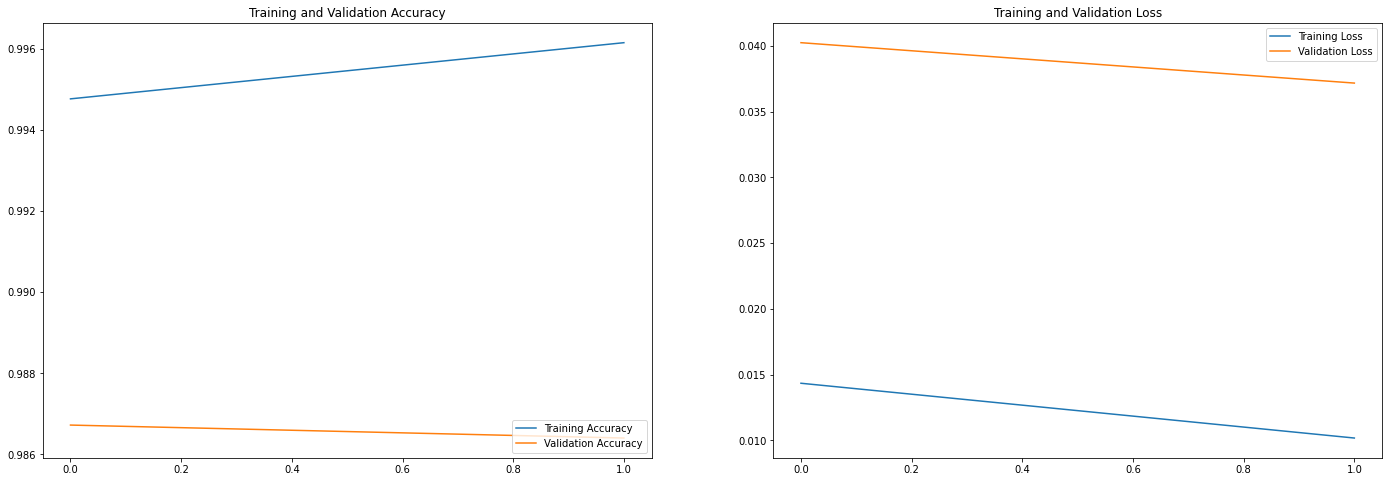

In [ ]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict

In [ ]:
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
test_data_transform = data_transforms['val']

ids = []
labels = []

with torch.no_grad():
    for test_path in tqdm(test_list):
        img = Image.open(test_path)
        img = test_data_transform(img)
        img = img.unsqueeze(0)
        img = img.to(device)

        model_ft.eval()
        outputs = model_ft(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        test_id = extract_class_from(test_path)
        ids.append(int(test_id))
        labels.append(preds[0])

torch.float32
torch.int64


196


Confusion Matrix : 



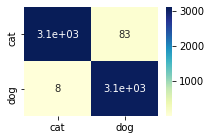

In [ ]:
#Confusion Matrix

#device = 'cpu'
inputs,labels = next(iter(tqdm(dataloaders_dict['val'])))

inputs = inputs.to(device)
labels = labels.to(device)

outputs = model_ft(inputs)

preds = torch.max(outputs,1)[1]
preds = preds.to(torch.float32)
preds = preds.to('cpu')

labels = labels.to('cpu')

print(preds.dtype)
print(labels.dtype)

Conf_Mat = confusion_matrix(preds,labels)

#Conf_Mat

print(len(tqdm(dataloaders_dict['val'])))

for i in range(len(tqdm(dataloaders_dict['val']))-1):
    

    inputs,labels = next(iter(tqdm(dataloaders_dict['val'])))
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_ft(inputs)

    preds = torch.max(outputs,1)[1]
    preds = preds.to(torch.float32)
    preds = preds.to('cpu')

    labels = labels.to('cpu')

    Conf_Mat += confusion_matrix(preds,labels)
print("Confusion Matrix : ")


classes = ('cat','dog')

df_cm = pd.DataFrame(Conf_Mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (3,2))
sn.heatmap(df_cm,cmap="YlGnBu",annot=True)#,fmt='.2%')
plt.savefig('/content/drive/MyDrive/Gruppenarbeit_NN/Daniel/Confusion_Matrix.png')

Check how well the prediction went

In [ ]:
### copy model to drive
model_save_name = 'Vgg16_pytorch.pt'
path = F"/content/drive/MyDrive/Gruppenarbeit_NN/Daniel/{model_save_name}" 
torch.save(model_ft.state_dict(), path)

In [ ]:
template = '"{}" with {:.2%} confidence'
def pred_result_message(pred):
    if pred > 0.5:
        return template.format('dog', pred)
    else:
        return template.format('cat', 1 - pred)

fig, axes = plt.subplots(nrows=5,
                         ncols=4,
                         figsize=(24, 24))
for img_path, label, ax in zip(test_list, labels, axes.ravel()):
    ax.set_title(pred_result_message(label))
    ax.imshow(Image.open(img_path))